# Introduction

Now that we have a set of labeled images we are ready to train a custom object detection model using transfer learning. We will be leveraging a pre-trained TensorFlow model, specifically the SSD Mobilenet V2 Object Detection model with FPN-Lite feature extractor.

The process we'll follow includes preparing the data, training the model, and evaluating the results.  Once our model is trained and evaluated, we'll convert it to TFLite format. This conversion allows our model to be deployed on edge devices, which are often constrained by factors such as processing power and memory. Finally, we'll test and validate our model on a few test images to ensure it's working as expected. This step is crucial as it gives us a practical understanding of how well our model performs in real-world scenarios.

By the end of this notebook, you'll have a custom-trained object detection model ready for deployment on an edge device. Let's get started!

**NOTE:** The training dataset used for this example consisted of 163 images of items found in a pantry, with 4 classes that were used to fine-tune the model, adapting it to our specific use-case.  This dataset and annotations file is provided in the repo in the `sample-data` folder.

# Setup

## Setup Notebook Environment

Once you have completed the **Compute Setup** steps from the repo (you only need to do this the first time) you are ready to work through this Notebook.

First, select the "Tensorflow" kernel for training models that was setup.

![TF_Kernel](images/TF_kernel.png)

In [1]:
import os
import warnings
import tensorflow as tf
warnings.filterwarnings('ignore') # Ignore all the warning messages in this tutorial

import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import glob

import json
import shutil
from sklearn.model_selection import train_test_split

from pycocotools.coco import COCO

%matplotlib inline

2023-10-30 22:45:34.429120: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-30 22:45:35.286851: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-10-30 22:45:35.286924: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-10-30 22:45:35.286931: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [2]:
print('TensorFlow version:', tf.__version__)  #2.11.0 as of October 2023 on AML with the version of TF used.

TensorFlow version: 2.11.0


## Initialize Constants

There are a few key constants used throughout the notebook, set these based on your specific environment.

In [3]:
# Model name can be anything you want
MODEL_NAME="meraki_azure_model"

# Set this to the path on terminal used for Azure Machine Learning Notebooks (should be your username)
USER_NAME = "camatthews"

USER_PATH = f'/home/azureuser/cloudfiles/code/Users/{USER_NAME}/meraki-customcv-azure/object-detection'

## Create Working Directories

In [4]:
#check that is formatted properly and switch to the directory setup in previous step
%cd {USER_PATH}/Tensorflow

/mnt/batch/tasks/shared/LS_root/mounts/clusters/meraki-gpu/code/Users/camatthews/meraki-customcv-azure/object-detection/Tensorflow


In [5]:
# The workspace directories are specific to the custom object detection model.
os.makedirs("workspace/" + MODEL_NAME + "/annotations", exist_ok=True)
os.makedirs("workspace/" + MODEL_NAME + "/inference", exist_ok=True)
os.makedirs("workspace/" + MODEL_NAME + "/output_training", exist_ok=True)
os.makedirs("workspace/" + MODEL_NAME + "/pre-trained-models", exist_ok=True)
os.makedirs("workspace/" + MODEL_NAME + "/tflite_models", exist_ok=True)

# Prepare Data

In the next section we setup the COCO Annotation file with the path to the images on the terminal used for training models, then generate TF Record files for the image data.

## Upload Images

1. Upload the folder that contains the images captured from the Meraki camera.  For this example, we used a folder called `all_images` that was stored locally, then upload the entire folder at once from the 'Menu Options' located by selecting the ellipsis next to the object-detection folder, or the Add symbol from the 'Files' menu.  **NOTE** The images folder contains images used in this notebook for documentation, you do NOT want to use it for your dataset!


2. Upload your file with COCO annotations (exported from Labeling Project) to your `{USER_PATH}` (where this notebook resides - one level up from all_images created in the first step).

![Upload_Files](images/Notebooks_Upload.png)

Once the images folder and annotations file have been uploaded, your directory structure should look like this:

![After_Images](images/images_uploaded.png)


## Confirm Image File Format 

All images should be encoded in RGB format and saved as jpg, the next section will convert any image files you may have that aren't already in this format.



In [6]:
source_img_dir=('all_images')  #the folder of images you uploaded
%cd {USER_PATH}/{source_img_dir}

/mnt/batch/tasks/shared/LS_root/mounts/clusters/meraki-gpu/code/Users/camatthews/meraki-customcv-azure/object-detection/all_images


In [7]:
if not "converted" in os.listdir():
	os.mkdir("converted")

lst_imgs_png = [i for i in glob.glob("*.png")]
print('PNG Files:', lst_imgs_png)

lst_imgs_jpg = [i for i in glob.glob("*.jpg")]
print('JPG Files:', lst_imgs_jpg)

for i in lst_imgs_png:
	img = Image.open(i)
	img = img.convert("RGB")
	img.save("converted/"+i.replace(".png", ".jpg"), "JPEG")

for i in lst_imgs_jpg:
	img = Image.open(i)
	img = img.convert("RGB")
	img.save("converted/"+i.replace(".png", ".jpg"), "JPEG")

print("Done converting.")

PNG Files: []
JPG Files: ['1snap_1.jpg', '1snap_10.jpg', '1snap_2.jpg', '1snap_3.jpg', '1snap_4.jpg', '1snap_5.jpg', '1snap_6.jpg', '1snap_7.jpg', '1snap_8.jpg', '1snap_9.jpg', 'all_snap_1.jpg', 'all_snap_10.jpg', 'all_snap_11.jpg', 'all_snap_12.jpg', 'all_snap_13.jpg', 'all_snap_14.jpg', 'all_snap_15.jpg', 'all_snap_16.jpg', 'all_snap_17.jpg', 'all_snap_18.jpg', 'all_snap_19.jpg', 'all_snap_2.jpg', 'all_snap_20.jpg', 'all_snap_3.jpg', 'all_snap_4.jpg', 'all_snap_5.jpg', 'all_snap_6.jpg', 'all_snap_7.jpg', 'all_snap_8.jpg', 'all_snap_9.jpg', 'chili2_snap_1.jpg', 'chili2_snap_10.jpg', 'chili2_snap_2.jpg', 'chili2_snap_3.jpg', 'chili2_snap_4.jpg', 'chili2_snap_5.jpg', 'chili2_snap_6.jpg', 'chili2_snap_7.jpg', 'chili2_snap_8.jpg', 'chili2_snap_9.jpg', 'chili_snap_1.jpg', 'chili_snap_10.jpg', 'chili_snap_2.jpg', 'chili_snap_3.jpg', 'chili_snap_4.jpg', 'chili_snap_5.jpg', 'chili_snap_6.jpg', 'chili_snap_7.jpg', 'chili_snap_8.jpg', 'chili_snap_9.jpg', 'IMG_7913.jpg', 'IMG_7914.jpg', 'IMG_791

## Update file paths in Annotation file

The COCO file exported from the AML Labeling project needs to be updated to reference the images in this Notebook workspace/terminal.

Open the COCO file and note the file path for your images in the COCO file.  You will modify that to use the file path to the files your Notebook accesses.

![COCO_File_Path](images/COCO_FilePath.png)

In [8]:
%cd {USER_PATH}

/mnt/batch/tasks/shared/LS_root/mounts/clusters/meraki-gpu/code/Users/camatthews/meraki-customcv-azure/object-detection


In [9]:
all_annotations_file='all_images_annotations.json'  # your annotation file name

In [10]:
# From the COCO file, replace the labeling project portion of path with the name of the folder you created (e.g. all_images)
labeling_project_path = "UI/2023-09-14_194508_UTC/meraki_food_all" # from our example

In [11]:
# Load the original COCO dataset (exported from labeling project)
with open(all_annotations_file, 'r') as f:
    data = json.load(f)

# First, remove image paths from the labeling project location
for record in data['images']:
    if labeling_project_path in record['file_name']:
        record['file_name'] = record['file_name'].replace(labeling_project_path, source_img_dir)

# OPTIONAL: Write the updated data back to a JSON file; this isn't neccessary as we write new files in the next step
# with open('all_images_annotations_updated.json', 'w') as f:
#     json.dump(data, f, indent=4)

## Split Images into Test/Train

We leave all the images in one directory and create two annotation files, one pointing to the percentage of images for training, and the other for test.

In [12]:
train_annotations_file='train_annotations.json'  # new file will be created with the split of training images
test_annotations_file='test_annotations.json' # new file to be created with split of test images

In [13]:
# Split the images into training and test sets
train_images, test_images = train_test_split(data['images'], test_size=0.2, random_state=42)

# Get the ids of the training and testing images
train_ids = [image['id'] for image in train_images]
test_ids = [image['id'] for image in test_images]

# Split the annotations into training and testing sets based on the image ids
train_annotations = [annotation for annotation in data['annotations'] if annotation['image_id'] in train_ids]
test_annotations = [annotation for annotation in data['annotations'] if annotation['image_id'] in test_ids]

# Format the contents of the training and testing annotation files
train_data = {'images': train_images, 'annotations': train_annotations, 'categories': data['categories']}
test_data = {'images': test_images, 'annotations': test_annotations, 'categories': data['categories']}

# Save the training and testing datasets to json files
with open(train_annotations_file, 'w') as f:
    json.dump(train_data, f)

with open(test_annotations_file, 'w') as f:
    json.dump(test_data, f)

## Check Annotation Changes (Optional)

Load the training dataset and view a few images to check labels and annotations.


In [14]:
%cd {USER_PATH}

/mnt/batch/tasks/shared/LS_root/mounts/clusters/meraki-gpu/code/Users/camatthews/meraki-customcv-azure/object-detection


In [15]:
#Loading object detection annotations for training dataset
coco=COCO(train_annotations_file)

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!


In [16]:
#training set details
imgIds = coco.getImgIds()
print("Total images: {}".format(len(imgIds)))

# select an image file at random and view properties
rand=np.random.randint(0,len(imgIds))
img = coco.loadImgs(imgIds[rand])[0]
#print("Image example:")
#print(img)

#and check the annotations with an example
annIds=coco.getAnnIds()
print("\nTotal annotations: {}".format(len(annIds)))
ann=coco.loadAnns(coco.getAnnIds(imgIds=img['id']))
print("Annotation example:")
print(ann[0])

Total images: 130

Total annotations: 291
Annotation example:
{'id': 281, 'category_id': 2, 'image_id': 127, 'area': 1182168.0, 'bbox': [1669.0, 790.0, 936.0, 1263.0]}


In [17]:
# classes are in the annotation file as well
categories = coco.loadCats(coco.getCatIds())
print("Number of categories: {}".format(len(categories)))
category_names=[cat['name'] for cat in categories]
print('\nCOCO categories: \n{}\n'.format(', '.join(category_names)))

Number of categories: 4

COCO categories: 
Corn, Chili, Pasta, Mac_N_Cheese



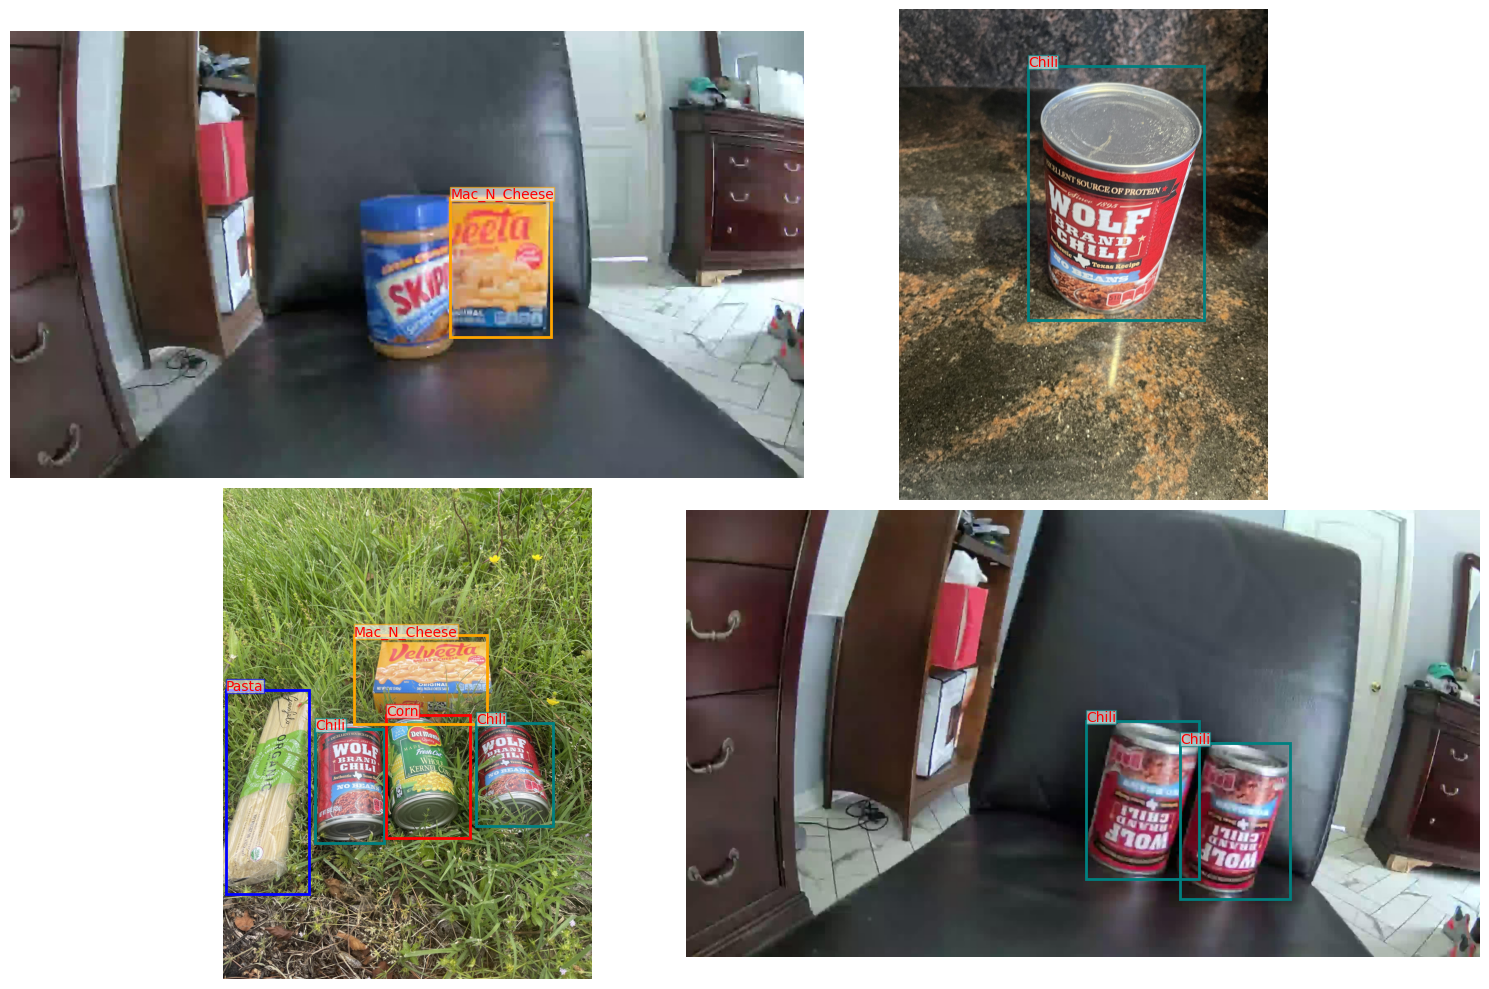

In [18]:
# define a list of colors for drawing bounding boxes (determine based on the number of classes in your images)
color_list = ["pink", "red", "teal", "blue", "orange", "yellow", "black", "magenta","green","aqua"]*10  # up to 100 colors available

# randomly pick images to display
num_imgs_to_disp = 4

total_images = len(coco.getImgIds()) # total number of images in the dataset
sel_img_idxs = np.random.permutation(total_images)[:num_imgs_to_disp]
imgIds = coco.getImgIds()
selected_img_ids = [imgIds[i] for i in sel_img_idxs]
annIds = coco.getAnnIds(selected_img_ids)

# setup display
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,10))
ax = ax.ravel()
for i, im in enumerate(selected_img_ids):
    img = coco.loadImgs(im)[0]
    file_name = img['file_name']
    image = Image.open(file_name)
    ann_ids = coco.getAnnIds(im)
    annotations = coco.loadAnns(ann_ids)
    for ann in annotations:
        bbox = ann['bbox']
        x, y, w, h = [int(b) for b in bbox]
        class_id = ann["category_id"]
        class_name = coco.loadCats(class_id)[0]["name"]
        color_ = color_list[class_id]
        rect = plt.Rectangle((x, y), w, h, linewidth=2, edgecolor=color_, facecolor='none')
        t_box=ax[i].text(x, y, class_name,  color='red', fontsize=10)
        t_box.set_bbox(dict(boxstyle='square, pad=0', facecolor='white', alpha=0.6, edgecolor=color_))
        ax[i].add_patch(rect)
    
    ax[i].axis('off')
    ax[i].imshow(image)
    ax[i].set_xlabel('Longitude')

plt.tight_layout()
plt.show()

## Generate TFRecord Files

A TFRecord is a binary file format used in Tensorflow to store data as a sequence of binary records.  Each record contains named features, in our case images and their corresponding label information.

The TFRecord files will be generated into the workspace directory; you can put them anywhere, but the rest of this notebook and command scripts that reference them are expecting this location, so if you change it be aware of changing those too.

In [19]:
train_outputpath = f'{USER_PATH}/Tensorflow/workspace/{MODEL_NAME}/annotations/Train.tfrecord'
test_outputpath = f'{USER_PATH}/Tensorflow/workspace/{MODEL_NAME}/annotations/Test.tfrecord'

In [20]:
import hashlib
from object_detection.utils import dataset_util

In [21]:
def create_tf_record_from_coco_annotations(coco_annotation_path, train_output_path):

    coco = COCO(coco_annotation_path)
    writer = tf.io.TFRecordWriter(train_output_path)

    for index, img_id in enumerate(coco.getImgIds()):
        img = coco.loadImgs(img_id)[0]
        img_file_name = img['file_name']
        img_height = img['height']
        img_width = img['width']
        full_path = img_file_name

        with tf.io.gfile.GFile(full_path, 'rb') as fid:
            encoded_jpg = fid.read()

        key = hashlib.sha256(encoded_jpg).hexdigest()
        feature_dict = {
            'image/height': dataset_util.int64_feature(img_height),
            'image/width': dataset_util.int64_feature(img_width),
            'image/filename': dataset_util.bytes_feature(img_file_name.encode('utf8')),
            'image/source_id': dataset_util.bytes_feature(str(img_id).encode('utf8')),
            'image/key/sha256': dataset_util.bytes_feature(key.encode('utf8')),
            'image/encoded': dataset_util.bytes_feature(encoded_jpg),
            'image/format': dataset_util.bytes_feature('jpeg'.encode('utf8')),
        }

        ann_ids = coco.getAnnIds(imgIds=img_id)
        objs = coco.loadAnns(ann_ids)
        boxes = []
        classes = []
        for obj in objs:
            x1, y1, width, height = obj['bbox']
            x2 = x1 + width
            y2 = y1 + height
            box = [y1 / img_height, x1 / img_width, y2 / img_height, x2 / img_width]
            boxes.append(box)
            classes.append(obj['category_id'])

        boxes = np.array(boxes)
        feature_dict.update({
            'image/object/bbox/ymin': dataset_util.float_list_feature(boxes[:, 0]),
            'image/object/bbox/xmin': dataset_util.float_list_feature(boxes[:, 1]),
            'image/object/bbox/ymax': dataset_util.float_list_feature(boxes[:, 2]),
            'image/object/bbox/xmax': dataset_util.float_list_feature(boxes[:, 3]),
            'image/object/class/label': dataset_util.int64_list_feature(classes),
        })

        example = tf.train.Example(features=tf.train.Features(feature=feature_dict))
        writer.write(example.SerializeToString())

    writer.close()

In [22]:
create_tf_record_from_coco_annotations(train_annotations_file, train_outputpath)

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


In [23]:
create_tf_record_from_coco_annotations(test_annotations_file, test_outputpath)

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!


## Create Label Map File

The label map file will be created from the annotation files, then stored along with the TFRecord files.

For our example, the file will have 4 class names.  Note the order isn't important, but the names should match exactly to the labels you used.

```
item {
    id: 1
    name: 'Corn'
}
item {
    id: 2
    name: 'Chilli'
}
item {
    id: 3
    name: 'Pasta'
}
item {
    id: 4
    name: 'Mac_n_cheese'
}
```

In [24]:
%cd {USER_PATH}

#Loading object detection annotations for training dataset
coco=COCO(train_annotations_file)

# classes are in the annotation file as well
categories = coco.loadCats(coco.getCatIds())
print("Number of categories: {}".format(len(categories)))
category_names=[cat['name'] for cat in categories]
print('\nCOCO categories: \n{}\n'.format(', '.join(category_names)))

pbtxt_content = ""

for item in categories:
    pbtxt_content += "item {\n"
    pbtxt_content += "    id: " + str(item['id']) + "\n"
    pbtxt_content += "    name: '" + item['name'] + "'\n"
    pbtxt_content += "}\n"


with open(f'{USER_PATH}/Tensorflow/workspace/{MODEL_NAME}/annotations/label_map.pbtxt', 'w') as f:
    f.write(pbtxt_content)

/mnt/batch/tasks/shared/LS_root/mounts/clusters/meraki-gpu/code/Users/camatthews/meraki-customcv-azure/object-detection
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Number of categories: 4

COCO categories: 
Corn, Chili, Pasta, Mac_N_Cheese



## Check TFRecord Files (Optional)

First, determine the keys/datatypes of the records in the binary TFRecord file.

In [25]:
import tensorflow as tf

def print_tfrecord_keys_and_datatypes(tfrecord_file_path, num_records=10):
    raw_dataset = tf.data.TFRecordDataset(tfrecord_file_path)
    
    for i, raw_record in enumerate(raw_dataset.take(num_records)):
        example = tf.train.Example()
        example.ParseFromString(raw_record.numpy())
        print(f'Record {i + 1} keys and datatypes:')
        for key, feature in example.features.feature.items():
            print(f'{key}: {feature.WhichOneof("kind")}')
        print('\n')

In [ ]:
# Replace with your tfrecord file path
tfrecord_file_path = test_outputpath
print_tfrecord_keys_and_datatypes(tfrecord_file_path)

You should see output similar to:

```
Record 1 keys and datatypes:
image/object/bbox/xmax: float_list
image/object/bbox/xmin: float_list
image/filename: bytes_list
image/object/bbox/ymin: float_list
image/width: int64_list
image/key/sha256: bytes_list
image/encoded: bytes_list
image/source_id: bytes_list
image/format: bytes_list
image/object/bbox/ymax: float_list
image/object/class/label: int64_list
image/height: int64_list
```

Use those keys/datatypes to update the feature description dictionary, then you can decode to view the image and values.

In [27]:
def display_tfrecord(tfrecord_file_path, num_records=5):
    raw_dataset = tf.data.TFRecordDataset(tfrecord_file_path)

    # Define the features in the TFRecord file
    feature_description = {
        'image/encoded': tf.io.FixedLenFeature([], tf.string),
        'image/object/bbox/ymax': tf.io.VarLenFeature(tf.float32),
        'image/height': tf.io.FixedLenFeature([], tf.int64),
        'image/object/class/label': tf.io.VarLenFeature(tf.int64),
        'image/format': tf.io.FixedLenFeature([], tf.string),
        'image/object/bbox/ymin': tf.io.VarLenFeature(tf.float32),
        'image/width': tf.io.FixedLenFeature([], tf.int64),
        'image/filename': tf.io.FixedLenFeature([], tf.string)
    }

    def _parse_function(example_proto):
        # Parse the input `tf.train.Example` proto using the dictionary above.
        return tf.io.parse_single_example(example_proto, feature_description)

    parsed_dataset = raw_dataset.map(_parse_function).take(num_records)

    for features in parsed_dataset:
        image = tf.image.decode_jpeg(features['image/encoded'], channels=3)
        plt.imshow(image)
        plt.show()

        print('Filename:', features['image/filename'].numpy().decode())
        print('Format:', features['image/format'].numpy().decode())
        print('Height:', features['image/height'].numpy())
        print('Width:', features['image/width'].numpy())
        print('Bounding Box YMin:', features['image/object/bbox/ymin'].values.numpy())
        print('Bounding Box YMax:', features['image/object/bbox/ymax'].values.numpy())
        print('Class Label:', features['image/object/class/label'].values.numpy())



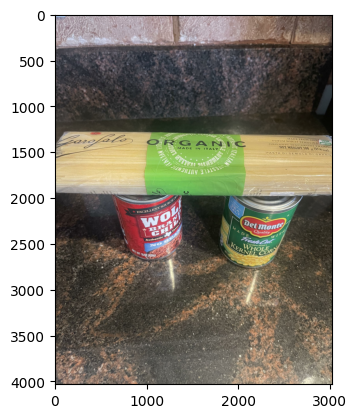

Filename: all_images/IMG_7950.jpg
Format: jpeg
Height: 4032
Width: 3024
Bounding Box YMin: [0.49082342 0.3139881  0.49900794]
Bounding Box YMax: [0.66071427 0.4920635  0.6909722 ]
Class Label: [2 3 1]


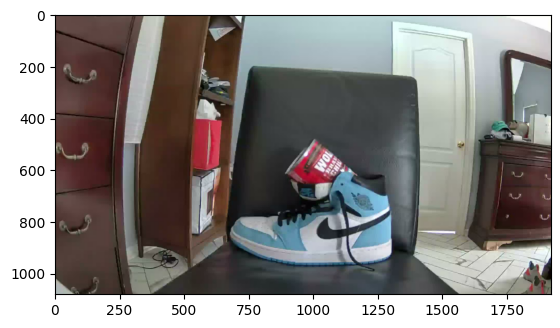

Filename: all_images/chili2_snap_10.jpg
Format: jpeg
Height: 1080
Width: 1920
Bounding Box YMin: [0.44351852]
Bounding Box YMax: [0.59074074]
Class Label: [2]


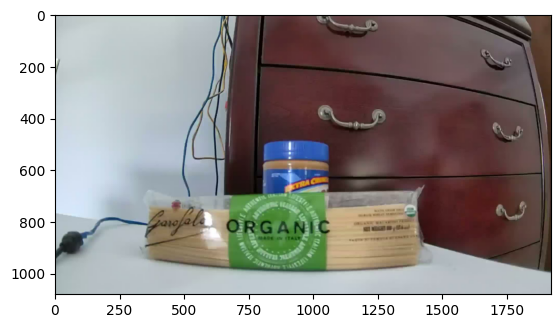

Filename: all_images/pasta_snap_2.jpg
Format: jpeg
Height: 1080
Width: 1920
Bounding Box YMin: [0.6157407]
Bounding Box YMax: [0.9203704]
Class Label: [3]


In [28]:
tfrecord_file_path = test_outputpath
display_tfrecord(tfrecord_file_path, 3)

# Training

In this demo, we use transfer learning with a pre-trained model to save training time. This technique leverages a model already proficient in object detection and fine-tunes it to our specific dataset of labeled images.  Commonly in computer vision, models trained on general datasets (like the COCO dataset) are fine-tuned to recognize specific labels. We’ll use an SSD Mobilenet V2 model trained on the COCO dataset, but feel free to experiment with other models from the model garden.

Mobilenets are a type of CNN designed for mobile and embedded vision applications optimized for low latency.

SSD is Single Shot Detection/Detector, is an algorithm specialized in object detection at low latency and high accuracy that is very common in the object detection and computer vision field.

For more information about this model, see [SSD Mobilenet V2 Object Detection model with FPN-Lite feature extractor](https://www.kaggle.com/models/tensorflow/ssd-mobilenet-v2/frameworks/tensorFlow2/variations/fpnlite-320x320).



## Obtain a pre-trained model for transfer learning

First we need to download the pre-trained model checkpoints and setup within our workspace.

**NOTE** You only need to download the model the first time you run this demo.

In [29]:
%cd {USER_PATH}/TensorFlow/workspace/{MODEL_NAME}/pre-trained-models

/mnt/batch/tasks/shared/LS_root/mounts/clusters/meraki-gpu/code/Users/camatthews/meraki-customcv-azure/object-detection/TensorFlow/workspace/meraki_azure_model/pre-trained-models


In [31]:
!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz

--2023-10-26 23:17:19--  http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 142.250.115.207, 142.250.114.207, 142.250.113.207, ...
Connecting to download.tensorflow.org (download.tensorflow.org)|142.250.115.207|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20515344 (20M) [application/x-tar]
Saving to: ‘ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz’

ssd_mobilenet_v2_fp 100%[===================>]  19.56M  42.3MB/s    in 0.5s    

2023-10-26 23:17:20 (42.3 MB/s) - ‘ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz’ saved [20515344/20515344]



In [32]:
# Extract the checkpoints and associated files.
!tar -xzvf ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz

ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/
ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/
ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/ckpt-0.data-00000-of-00001
ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/checkpoint
ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/ckpt-0.index
ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/pipeline.config
ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/saved_model/
ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/saved_model/saved_model.pb
ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/saved_model/variables/
ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/saved_model/variables/variables.data-00000-of-00001
ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/saved_model/variables/variables.index


## Transfer Learning

We will use a script from the TensorFlow Object Detection API to control the training process.  

The steps we will follow to setup the training process:

1. Edit the configuration script for the model.

2. Generate the command we will run from the console.

3. Switch to the Terminal and execute the commands at the console.



## Edit `pipeline.config` Script

The model downloaded in the previous step has a configuration file at `{USER_PATH}/TensorFlow/workspace/{MODEL_NAME}/pre-trained-models/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/` named `pipeline.config` which specifies the structure of the neural network and several learning parameters that impact the training process. 

A summary of key configuration settings:

* `num_classes`: Number of classes in your model.
* `batch_size`: Batch size refers to the number of training set images shown to the model at once. Larger batches can speed up training but require more memory and resources 
* `fine_tune_checkpoint`: The directory used for resuming interrupted training from the last checkpoint, ensuring no progress is lost.
* `fine_tune_checkpoint_type`: Specifies the model type for training. It can be `classification` for scene or image categorization, or `detection` for object recognition within images using bounding boxes and class. For our task, we’ll use `detection`.
* `num_steps`: The number of training iterations for your model. While more steps can improve accuracy, it also increases training time. Note that excessive training can lead to decreased model performance, so moderation is key.
* `optimizer`: The algorithm used to adjust the neural network's parameters during training. 
* `learning_rate`: Determines how aggressively the optimizer adjusts the parameters during training. Higher learning rates can speed up training but at the expense of possibly learning the wrong patterns and reducing model accuracy.  Typically, start with a low learning rate, then increase it mid-training, then decrease it towards the end. `learning_rate_base` is the desired rate for most of the training, `warmup_learning_rate` is the starting rate, and `warmup_steps` define how quickly the `warmup_learning_rate` should reach the `learning_rate_base`.

The next steps provide guidance for modifying the script to train on the custom set of images. 

**TIP:** Create a backup copy of the original `pipeline.config` file in case you want to reference it in the future (Duplicate and rename in the Notebooks UI).

**NOTE:** Anywhere you see variables in curly braces (e.g. `{MODEL_NAME}`) type the actual value in the pipeline file.  The script cannot reference the variables we've defined throughout the notebook.


### `num_classes`

Toward the beginning of the file you'll see the `num_classes` parameter.

```
model {
  ssd {
    num_classes: 90
    image_resizer {
      fixed_shape_resizer {
        height: 320
        width: 320
```

The default is 90 - change this to reflect the total number of classes in your dataset.  In our example, **4 ** classes.



### `batch_size`

Towards the middle of the file, look for the `batch_size` parameter.

```
train_config {
  batch_size: 64
  data_augmentation_options {
    random_horizontal_flip {
    }
  }

```
  
Batch size refers to the number of training set images shown to the model at once. Larger batches can speed up training but require more memory and resources.  Depending on your training set size, you will want to adjust the batch_size parameter accordingly. **The demo dataset has 130 images for training with a batch_size of 16.**

### `optimizer`
The next section within `train_config` to look for is `optimizer`.  

```
  optimizer {
    momentum_optimizer {
      learning_rate {
        cosine_decay_learning_rate {
          learning_rate_base: 0.09999999910593033
          total_steps: 50000
          warmup_learning_rate: 0.033333000242710114
          warmup_steps: 500
        }
      }
      momentum_optimizer_value: 0.8999999761581421
    }
    use_moving_average: false
```
The settings shown here worked well for 130 training images and 4 classes.  

**Make the following changes in your file:**
```
* learning_rate_base : 0.09999999910593033
* warmup_learning_rate : 0.033333000242710114
* warmup_steps : 500
```

### `fine_tune_checkpoint`

The next section has the `fine_tune_checkpoint` configuration.

```
  }
  fine_tune_checkpoint: "PATH_TO_BE_CONFIGURED"
  num_steps: 25000
  startup_delay_steps: 0.0
  replicas_to_aggregate: 8
  max_number_of_boxes: 100
  unpad_groundtruth_tensors: false
  fine_tune_checkpoint_type: "classification"
  fine_tune_checkpoint_version: V2
}
```

This configures the directory that will contain the checkpoint files generated during training; these files can be used to resume from an interrupted training run if needed. You will set this path to the output folder for your model.  In the next section we will setup the files for this directory.

We will use a smaller `num_steps` to reduce the time it takes for the model to train, setting this to 2000 instead of 25000.

Also, we need to set the `fine_tune_checkpoint_type` to `detection` as this is the type of model we are training.

**Make the following changes in your file:**

```
* fine_tune_checkpoint: "{USER_PATH}/Tensorflow/workspace/{MODEL_NAME}/checkpoint/ckpt-0"`  
* num_steps: 2000
* fine_tune_checkpoint_type: "detection"

```

**NOTE:** Make sure to type the values for `{USER_PATH}` and `{MODEL_NAME}` in directly.  For example the path would look like: `"/home/azureuser/cloudfiles/code/Users/camatthews/meraki-customcv-azure/object-detection/TensorFlow/workspace/meraki_azure_model/checkpoint/ckpt-0" `

### `tf_record_input_reader` and `label_map_path`

Towards the end of the file you will see a section for `train_input_reader`.  This section specifies the location of the training images dataset and the file mapping the labels to the integers associated with each class.

```
train_input_reader {
  label_map_path: "PATH_TO_BE_CONFIGURED"
  tf_record_input_reader {
    input_path: "PATH_TO_BE_CONFIGURED"
  }
}
```

Make the following changes:

1. Set `label_map_path`: "`{USER_PATH}`/Tensorflow/workspace/`{MODEL_NAME}`/annotations/label_map.pbtxt".

2. Set `tf_record_input_reader` : "`{train_outputpath}`"  The location of the train.tfrecord file you generated for the images dataset.

**NOTE:** Make sure to type the values for `{USER_PATH}`, `{MODEL_NAME}` and `{train_outputpath}` in directly.  For example: 

```
train_input_reader {
  label_map_path: "/home/azureuser/cloudfiles/code/Users/camatthews/meraki-customcv-azure/object-detection/TensorFlow/workspace/meraki_azure_model/annotations/label_map.pbtxt"
  tf_record_input_reader {
    input_path: "/home/azureuser/cloudfiles/code/Users/camatthews/meraki-customcv-azure/object-detection/TensorFlow/workspace/meraki_azure_model/annotations/Train.tfrecord"
  }
}
```

Next, look for the section called `eval_input_reader`, the last section in the file.  This configures the location for the test dataset records (test is called eval).  Again, make sure to type the paths in specifically.  

Make the following changes:

1. Set `label_map_path`: "`{USER_PATH}`/Tensorflow/workspace/`{MODEL_NAME}`/annotations/label_map.pbtxt".

2. Set `tf_record_input_reader` : "`{test_outputpath}`"  The location of the Test.tfrecord file you generated for the images dataset.

For example, your file should read similarly to this:

```
eval_input_reader {
  label_map_path: "/home/azureuser/cloudfiles/code/Users/camatthews/meraki-customcv-azure/object-detection/TensorFlow/workspace/meraki_azure_model/annotations/label_map.pbtxt"
  shuffle: false
  num_epochs: 1
  tf_record_input_reader {
    input_path: "/home/azureuser/cloudfiles/code/Users/camatthews/meraki-customcv-azure/object-detection/TensorFlow/workspace/meraki_azure_model/annotations/Test.tfrecord"
  }
  ```

Once these changes are made, save the file.

## Copy Initial Checkpoint Files

Next, copy the checkpoint files from the pre-trained model into our model workspace to the directory set in the `fine_tune_checkpoint` configuration.  

The training will start from those files and all subsequent checkpoint files will be stored as well, so model training can be restarted if interrupted.

Copy the files from `{USER_PATH}/Tensorflow/workspace/{MODEL_NAME}/pre-trained-models/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/` into `{USER_PATH}/Tensorflow/workspace/{MODEL_NAME}/checkpoint`.  

The easiest way to do this within the Azure Machine Learning UI is by using the menu options (ellipsis next to the folder name):

1. Duplicate the `checkpoint` folder in the pre-trained model directory, naming it to something else (e.g. `checkpoint-copy`).  
2. Move the duplicated folder into the `{MODEL_NAME}` directory.
3. Rename the folder to `checkpoint`

![ckpt_setup](images/checkpoint_copy.png)

## Generate Training Command 

We will generate the command you will run from the terminal window to execute the script to start the training leveraging the variables from this notebook.

In [30]:
# --pipeline_config_path should point to the pipeline.config file in the transfer learning model folder you edited in the previous step.
# --model_dir should point to the folder where your training output will go

train_cmd = f'python model_main_tf2.py \
--pipeline_config_path="{USER_PATH}/Tensorflow/workspace/{MODEL_NAME}/pre-trained-models/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/pipeline.config" \
--model_dir="{USER_PATH}/Tensorflow/workspace/{MODEL_NAME}/output_training/" \
--alsologtostderr'

print(train_cmd)

python model_main_tf2.py --pipeline_config_path="/home/azureuser/cloudfiles/code/Users/camatthews/meraki-customcv-azure/object-detection/Tensorflow/workspace/meraki_azure_model/pre-trained-models/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/pipeline.config" --model_dir="/home/azureuser/cloudfiles/code/Users/camatthews/meraki-customcv-azure/object-detection/Tensorflow/workspace/meraki_azure_model/output_training/" --alsologtostderr


## Start Training

The commands in this section should be run from the Terminal on the compute you created in the prerequisites, see [How to access terminal](https://learn.microsoft.com/en-us/azure/machine-learning/how-to-access-terminal?view=azureml-api-2) for details from within Azure Machine Learning. 

First, activate the TensorFlow environment associated with the kernel you have been using in the notebook.  In our example, it is the `TF` environment.

```
conda activate TF
```

Then, you go to the directory where we installed the TensorFlow Object Detection API:

```
cd Tensorflow/models/research/object_detection
```

Next, copy/paste the value in the `train_cmd` variable, this is what you will execute from the terminal to start the training process.

Here's an example of what the command should look like, but **use the one generated in the previous cell** that is specific to your environment.

```
python model_main_tf2.py --pipeline_config_path="/home/azureuser/cloudfiles/code/Users/camatthews/meraki-customcv-azure/object-detection/Tensorflow/workspace/meraki_azure_model/pre-trained-models/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/pipeline.config" --model_dir="/home/azureuser/cloudfiles/code/Users/camatthews/meraki-customcv-azure/object-detection/Tensorflow/workspace/meraki_azure_model/output_training/" --alsologtostderr
```


During training, the training script will send some console output of the form:

```
INFO:tensorflow:Step 1000 per-step time 0.118s
I0425 17:37:11.796032 140112274335616 model_lib_v2.py:707] Step 1000 per-step time 0.118s
INFO:tensorflow:{'Loss/classification_loss': 0.19940959,
 'Loss/localization_loss': 0.12937297,
 'Loss/regularization_loss': 0.1531889,
 'Loss/total_loss': 0.48197144,
 'learning_rate': 0.099974826}
```

This allows you to monitor your model's performance during each step of training.  


A summary of the metrics is:

* `classification_loss`: How good your model is at classifying objects within bounding boxes. This should show a downward trend during training, or you may need to tune parameters and/or get more/better data.

* `localization_loss`: How good your model is at finding the correct bounding boxes for objects. This should show a downward trend during training, or you may need to tune parameters and/or get more/better data.

* `regularization_loss`: How good your model is at generalizing what it learns, that is how good it is performing outside of the training data. Should follow a downward trend during training or you may need to obtain higher quality/more varied data.

* `total_loss`: Sum of the previous losses. Should show a downward trend during training.

* `learning_rate`: How much your model changes parameters in your neural network during each training cycle to find the optimal solution. Most of the time this starts relatively low, increases linearly for a while, and then flatlines until the end of training.

Additionally, you will see a few other datapoints:

* `Step`: How far along training you are. Each step is your model running through ALL of your training dataset and making predictions on it, and then updating its parameters before the next step.

* `Per-step time`: How long it takes your model to complete one run through your training data. Larger datasets and more complex models take longer to process, although this is also hardware-dependent.

The training will take 15-30 minutes depending on the GPU you selected.

## Troubleshooting

The training script will continuously output checkpoints into the `{USER_PATH}/TensorFlow/workspace/{MODEL_NAME}/output_training/` folder.

Your model's training could stop for several reasons:

* Script error or crash
* Running out of resources on your Compute.
* Disconnection from Compute.
* Manual stop

If you get errors related to resources on the compute, first try restarting the compute then return to the `Start Training` section and follow those steps.

If you don't want/need to restart the compute, you can restart training from a checkpoint in this manner:

Go to `{USER_PATH}/TensorFlow/workspace/{MODEL_NAME}/output_training/` and copy all of the checkpoint files (they start with ckpt-, plus one file called checkpoint) into the {USER_PATH}/TensorFlow/workspace/{MODEL_NAME}/checkpoint/ folder (erase any overlapping files and keep the new ones).  

Re-run the command script, and your model should resume automatically at the last checkpoint (Checkpoints are taken every 1000 steps by default).

# Evaluate Model

Once the training has completed, we can evaluate the results to assess the model’s overall performance in accurately detecting objects within a set of test images.

Key metrics used in this evaluation include:

* **Precision (P)**: This is the proportion of true positive detections out of all positive detections (true positives + false positives). It measures the model’s ability to correctly identify only the relevant objects.

* **Recall (R)**: This is the proportion of true positive detections out of all actual positives (true positives + false negatives). It measures the model’s ability to find all the relevant cases within a dataset.

* **Mean Average Precision (mAP)**: This is the average of the maximum precision value obtained for each recall value after plotting precision-recall curves for all classes. mAP provides a single score that balances both precision and recall, making it a popular metric for evaluating object detection models.

The evaluation process helps in understanding the model’s strengths and weaknesses, and guides further fine-tuning and optimization to improve its performance.

## Generate & Run Eval Command

First we will generate a command to run with the appropriate variables substituted in.

In [31]:
eval_cmd = f'python model_main_tf2.py \
--pipeline_config_path="{USER_PATH}/Tensorflow/workspace/{MODEL_NAME}/pre-trained-models/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/pipeline.config" \
--model_dir="{USER_PATH}/Tensorflow/workspace/{MODEL_NAME}/output_training/" \
--alsologtostderr \
--checkpoint_dir="{USER_PATH}/Tensorflow/workspace/{MODEL_NAME}/output_training"'

print(eval_cmd)

python model_main_tf2.py --pipeline_config_path="/home/azureuser/cloudfiles/code/Users/camatthews/meraki-customcv-azure/object-detection/Tensorflow/workspace/meraki_azure_model/pre-trained-models/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/pipeline.config" --model_dir="/home/azureuser/cloudfiles/code/Users/camatthews/meraki-customcv-azure/object-detection/Tensorflow/workspace/meraki_azure_model/output_training/" --alsologtostderr --checkpoint_dir="/home/azureuser/cloudfiles/code/Users/camatthews/meraki-customcv-azure/object-detection/Tensorflow/workspace/meraki_azure_model/output_training"


Copy/paste the value in the `eval_cmd` variable to your console to start the evaluation process.

Here's an example of what the command should look like, but **use the one generated in the previous cell** that is specific to your environment.

```
python model_main_tf2.py --pipeline_config_path="/home/azureuser/cloudfiles/code/Users/camatthews/meraki-customcv-azure/object-detection/Tensorflow/workspace/meraki_azure_model/pre-trained-models/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/pipeline.config" --model_dir="/home/azureuser/cloudfiles/code/Users/camatthews/meraki-customcv-azure/object-detection/Tensorflow/workspace/meraki_azure_model/output_training/" --alsologtostderr --checkpoint_dir="/home/azureuser/cloudfiles/code/Users/camatthews/meraki-customcv-azure/object-detection/Tensorflow/workspace/meraki_azure_model/checkpoint"
```

While the evaluation runs you should see output to the console similar to this:

```
INFO:tensorflow:Performing evaluation on 33 images.
I1025 23:28:47.450747 140592175265600 coco_evaluation.py:293] Performing evaluation on 33 images.
creating index...
index created!
INFO:tensorflow:Loading and preparing annotation results...
I1025 23:28:47.451795 140592175265600 coco_tools.py:116] Loading and preparing annotation results...
INFO:tensorflow:DONE (t=0.00s)
I1025 23:28:47.453437 140592175265600 coco_tools.py:138] DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.09s).
Accumulating evaluation results...
DONE (t=0.04s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.572
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.883
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.649
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.050
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.579
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.559
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.644
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.649
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.200
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.655
INFO:tensorflow:Eval metrics at step 2000
I1025 23:28:47.604898 140592175265600 model_lib_v2.py:1015] Eval metrics at step 2000
INFO:tensorflow:        + DetectionBoxes_Precision/mAP: 0.572036
I1025 23:28:47.610353 140592175265600 model_lib_v2.py:1018]     + DetectionBoxes_Precision/mAP: 0.572036
INFO:tensorflow:        + DetectionBoxes_Precision/mAP@.50IOU: 0.883027
I1025 23:28:47.611393 140592175265600 model_lib_v2.py:1018]     + DetectionBoxes_Precision/mAP@.50IOU: 0.883027
INFO:tensorflow:        + DetectionBoxes_Precision/mAP@.75IOU: 0.648905
I1025 23:28:47.612257 140592175265600 model_lib_v2.py:1018]     + DetectionBoxes_Precision/mAP@.75IOU: 0.648905
INFO:tensorflow:        + DetectionBoxes_Precision/mAP (small): -1.000000
I1025 23:28:47.613118 140592175265600 model_lib_v2.py:1018]     + DetectionBoxes_Precision/mAP (small): -1.000000
INFO:tensorflow:        + DetectionBoxes_Precision/mAP (medium): 0.050000
I1025 23:28:47.613979 140592175265600 model_lib_v2.py:1018]     + DetectionBoxes_Precision/mAP (medium): 0.050000
INFO:tensorflow:        + DetectionBoxes_Precision/mAP (large): 0.579422
I1025 23:28:47.614840 140592175265600 model_lib_v2.py:1018]     + DetectionBoxes_Precision/mAP (large): 0.579422
INFO:tensorflow:        + DetectionBoxes_Recall/AR@1: 0.559282
I1025 23:28:47.615694 140592175265600 model_lib_v2.py:1018]     + DetectionBoxes_Recall/AR@1: 0.559282
INFO:tensorflow:        + DetectionBoxes_Recall/AR@10: 0.643532
I1025 23:28:47.616550 140592175265600 model_lib_v2.py:1018]     + DetectionBoxes_Recall/AR@10: 0.643532
INFO:tensorflow:        + DetectionBoxes_Recall/AR@100: 0.648532
I1025 23:28:47.617404 140592175265600 model_lib_v2.py:1018]     + DetectionBoxes_Recall/AR@100: 0.648532
INFO:tensorflow:        + DetectionBoxes_Recall/AR@100 (small): -1.000000
I1025 23:28:47.618136 140592175265600 model_lib_v2.py:1018]     + DetectionBoxes_Recall/AR@100 (small): -1.000000
INFO:tensorflow:        + DetectionBoxes_Recall/AR@100 (medium): 0.200000
I1025 23:28:47.619010 140592175265600 model_lib_v2.py:1018]     + DetectionBoxes_Recall/AR@100 (medium): 0.200000
INFO:tensorflow:        + DetectionBoxes_Recall/AR@100 (large): 0.654842
I1025 23:28:47.619890 140592175265600 model_lib_v2.py:1018]     + DetectionBoxes_Recall/AR@100 (large): 0.654842
INFO:tensorflow:        + Loss/localization_loss: 0.131995
I1025 23:28:47.620554 140592175265600 model_lib_v2.py:1018]     + Loss/localization_loss: 0.131995
INFO:tensorflow:        + Loss/classification_loss: 0.283950
I1025 23:28:47.621222 140592175265600 model_lib_v2.py:1018]     + Loss/classification_loss: 0.283950
INFO:tensorflow:        + Loss/regularization_loss: 0.138179
I1025 23:28:47.621883 140592175265600 model_lib_v2.py:1018]     + Loss/regularization_loss: 0.138179
INFO:tensorflow:        + Loss/total_loss: 0.554124
I1025 23:28:47.622561 140592175265600 model_lib_v2.py:1018]     + Loss/total_loss: 0.554124
INFO:tensorflow:Exiting evaluation at step 2000
I1025 23:28:47.731714 140592175265600 model_lib_v2.py:1168] Exiting evaluation at step 2000
```

You can use this as a benchmark to compare against if you want to make adjustments to the parameters or training data.

# Convert to TFLite

Once you are satisfied with the model results, the next step is to export the model and convert it to TFLite so it can be used on a device.

## Generate & Run Export Command

First,  we will export to a Saved_Model that contains a full fledged TensorFlow trained model, and can be loaded and used in the future for further training or for inference (detecting objects).

Script the command we will run from the terminal to export the files and created the Saved_Model.

In [32]:
export_cmd = f'python export_tflite_graph_tf2.py \
--trained_checkpoint_dir="{USER_PATH}/Tensorflow/workspace/{MODEL_NAME}/output_training" \
--pipeline_config_path="{USER_PATH}/Tensorflow/workspace/{MODEL_NAME}/pre-trained-models/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/pipeline.config" \
--output_directory "{USER_PATH}/Tensorflow/workspace/{MODEL_NAME}/inference"'

print(export_cmd)

python export_tflite_graph_tf2.py --trained_checkpoint_dir="/home/azureuser/cloudfiles/code/Users/camatthews/meraki-customcv-azure/object-detection/Tensorflow/workspace/meraki_azure_model/output_training" --pipeline_config_path="/home/azureuser/cloudfiles/code/Users/camatthews/meraki-customcv-azure/object-detection/Tensorflow/workspace/meraki_azure_model/pre-trained-models/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/pipeline.config" --output_directory "/home/azureuser/cloudfiles/code/Users/camatthews/meraki-customcv-azure/object-detection/Tensorflow/workspace/meraki_azure_model/inference"


Copy/paste the value in the `eval_cmd` variable to your console to export the model.

Here's an example of what the command should look like, but **use the one generated in the previous cell** that is specific to your environment.

```
python export_tflite_graph_tf2.py --trained_checkpoint_dir="/home/azureuser/cloudfiles/code/Users/camatthews/meraki-customcv-azure/object-detection/Tensorflow/workspace/meraki_azure_model/output_training" --pipeline_config_path="/home/azureuser/cloudfiles/code/Users/camatthews/meraki-customcv-azure/object-detection/Tensorflow/workspace/meraki_azure_model/pre-trained-models/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/pipeline.config" --output_directory "/home/azureuser/cloudfiles/code/Users/camatthews/meraki-customcv-azure/object-detection/Tensorflow/workspace/meraki_azure_model/inference"
```

Once this completes, you should see files/folders at {USER_PATH}/Tensorflow/workspace/meraki_azure_model/inference/saved_model.


## Change Kernel

**IMPORTANT NOTE:**

For the next section, change to the Tensorflow 2.5 kernel you setup in the initial steps.  TensorFlow 2.5 maintains a strict order for the output tensors, whereas models exported with higher versions will modify the order of their outputs and make them unusable with Meraki cameras. 


![TF25_Kernel](images/TF25_kernel.png)

If the selection box is not selectable, try closing and reopening this notebook file, which should refresh the selection.

In [1]:
import tensorflow as tf

2023-10-30 22:47:58.200764: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
#double check the version - should be 2.5.0
print(tf.__version__)

2.5.0


## Reinitialize Constants

We have to reinitialize the variables to use with this kernel.

In [3]:
# Model name used for this demonstration
MODEL_NAME="meraki_azure_model"

# Set this to the path on terminal used for Azure Machine Learning Notebooks 
USER_NAME = "camatthews"

USER_PATH = f'/home/azureuser/cloudfiles/code/Users/{USER_NAME}/meraki-customcv-azure/object-detection'

## Convert to TFLite

In [ ]:
# Create a TFLiteConverter object
converter = tf.lite.TFLiteConverter.from_saved_model(f"{USER_PATH}/TensorFlow/workspace/{MODEL_NAME}/inference/saved_model")

# Optimize your model for latency to allow near realtime inference
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_LATENCY]

# Convert Saved_Model to TFLite
tflite_model = converter.convert()

In [5]:
%cd {USER_PATH}/TensorFlow/workspace/{MODEL_NAME}/tflite_models

/mnt/batch/tasks/shared/LS_root/mounts/clusters/meraki-gpu/code/Users/camatthews/meraki-customcv-azure/object-detection/TensorFlow/workspace/meraki_azure_model/tflite_models


In [6]:
tflite_file_name = 'meraki-mobilenetv2-azure-pantry_model.tflite'

# Export the model as tflite
with open(tflite_file_name, 'wb') as f:
  f.write(tflite_model)

# Test Model with an Image

In [7]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd

import numpy as np
from PIL import Image
import pandas as pd

In [8]:
%matplotlib inline

In [9]:
%cd {USER_PATH}/TensorFlow/workspace/{MODEL_NAME}/tflite_models

/mnt/batch/tasks/shared/LS_root/mounts/clusters/meraki-gpu/code/Users/camatthews/meraki-customcv-azure/object-detection/TensorFlow/workspace/meraki_azure_model/tflite_models


In [10]:
interpreter = tf.lite.Interpreter(model_path=tflite_file_name)
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

#View outputs (just for reference)
pd.DataFrame(output_details)

,name,index,shape,shape_signature,dtype,quantization,quantization_parameters,sparsity_parameters
0,StatefulPartitionedCall:3,337,"[1, 10, 4]","[1, 10, 4]",<class 'numpy.float32'>,"(0.0, 0)","{'scales': [], 'zero_points': [], 'quantized_d...",{}
1,StatefulPartitionedCall:2,338,"[1, 10]","[1, 10]",<class 'numpy.float32'>,"(0.0, 0)","{'scales': [], 'zero_points': [], 'quantized_d...",{}
2,StatefulPartitionedCall:1,339,"[1, 10]","[1, 10]",<class 'numpy.float32'>,"(0.0, 0)","{'scales': [], 'zero_points': [], 'quantized_d...",{}
3,StatefulPartitionedCall:0,340,[1],[1],<class 'numpy.float32'>,"(0.0, 0)","{'scales': [], 'zero_points': [], 'quantized_d...",{}


In [11]:
img_path = f'{USER_PATH}/all_images'
img_path

'/home/azureuser/cloudfiles/code/Users/camatthews/meraki-customcv-azure/object-detection/all_images'

In [ ]:
image = Image.open(f'{img_path}/IMG_7964.jpg')  #change to one of your images
image

In [13]:
image = image.resize((320, 320)) 
input_data  = np.expand_dims(image, axis=0)
input_data = input_data.astype(np.float32)
input_data = tf.keras.applications.mobilenet_v2.preprocess_input(input_data)

# Set the input tensor
interpreter.set_tensor(input_details[0]['index'], input_data )

# Run inference
interpreter.invoke()

# For TF conversion version 2.5 the order is static (if you use another TF version, these may vary!)
boxes = interpreter.get_tensor(output_details[0]['index'])[0]
classes = interpreter.get_tensor(output_details[1]['index'])[0].astype(int)
scores = interpreter.get_tensor(output_details[2]['index'])[0]
num_detections = interpreter.get_tensor(output_details[3]['index'])

class_names = ['corn', 'chilli', 'pasta', 'Mac_n_cheese']  # modify for your classes (use annotation file!)

In [ ]:
fig, ax = plt.subplots()
ax.imshow(image)

im_dim = 320

# Draw the bounding boxes and class labels on the image
for i in range(int(num_detections)):
    if scores[i] > 0.5:
        print('score', scores[i])
        print('classnum', classes[i])
        print('class names', class_names[classes[i]])
        ymin, xmin, ymax, xmax = boxes[i]
        rect = patches.Rectangle((xmin*im_dim, ymin*im_dim), (xmax-xmin)*im_dim, (ymax-ymin)*im_dim, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(xmax*im_dim, ymax*im_dim, class_names[classes[i]], fontsize=12, color='r')

plt.show()

Ideally all the objects in the image should be detected, and the scores should be as close to 1 as possible to indicate higher certainty of the class.

An example image with 4 classes detected:


```
score 0.99964774
classnum 3
class names Mac_n_cheese
score 0.99897575
classnum 1
class names chilli
score 0.99319375
classnum 2
class names pasta
score 0.990497
classnum 0
class names corn
```

![Sample_Eval](images/sample_eval_image.jpg)


# Zip and Download Model

The Meraki Camera API expects a zip file containing just the tflite model file and named model.zip.

In [15]:
import zipfile

In [16]:
with zipfile.ZipFile('model.zip', 'w') as zip_file:
    zip_file.write(f'{USER_PATH}/TensorFlow/workspace/{MODEL_NAME}/tflite_models/{tflite_file_name}')

Now you can download the file from the menu options next to the zip file within the tflite_models directory, then you're ready to deploy it to the Meraki Camera!

# Deploy Model to Camera

Once you have your model file prepared, you can follow the steps to deploy your model to the camera using the Cisco Meraki Dashboard.  Detailed instructions can be found in the [MV Sense Custom Computer Vision](https://documentation.meraki.com/MV/Video_Analytics/MV_Sense_Custom_Computer_Vision) documentation.  